In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string,time
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from textblob import TextBlob
# this is done to correct the incorrect spelings.
from nltk.tokenize import word_tokenize
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 27.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
df = pd.read_excel("OSHA construction 4470 cases original.xlsx")
df.head()

,Unnamed: 0,id,title,Summary2,cause,newkeys
0,0,200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of Templ...,Other,"\nconstruction, undrgrd power line, highway, ..."
1,1,202673471,Foreman Is Fatally Crushed When Forklift Tips...,At approximately 6:30 a.m. on May 13 2013 Empl...,[],"\nconstruction, equipment operator, industria..."
2,2,202509832,Employee Suffers Abdominal Fracture In Fall F...,On April 9 2013 Employee #1 was installing vin...,Fall from/with ladder,"\ninstalling, ladder, scaffold, structure mov..."
3,3,201562840,Employee'S Body Is Caught In Asphalt Machine ...,On November 27 2012 Employee #1 was operating ...,Crushed/run,"\nasphalt, machine operator, caught by, cloth..."
4,4,202478632,Employee Is Punctured In Abdomen With Nail,At approximately 11:57 a.m. on September 28 20...,Other,"\nslip, nail, puncture, abdomen, fall\n"


In [13]:
print(f"Dataset shape : {df.shape}")

Dataset shape : (4470, 6)


In [14]:
df = df.drop(columns='id')

In [15]:
df = df.rename(columns={'0': 'Serial no', 'Summary2': 'Summary'})

In [16]:
#Column names

print(f"Feature names : {df.columns.values}")

Feature names : ['Unnamed: 0' 'title' 'Summary' 'cause' 'newkeys']


In [17]:
#Check for null values

df.isnull().sum()

,0
Unnamed: 0,0
title,0
Summary,0
cause,0
newkeys,0


In [18]:
#We will drop the null record

df.dropna(inplace=True)

In [19]:
df.dtypes

,0
Unnamed: 0,int64
title,object
Summary,object
cause,object
newkeys,object


In [20]:
df['newkeys']=df['newkeys'].str.lower()
df['cause']=df['cause'].str.lower()
df['title']=df['title'].str.lower()
df['Summary']=df['Summary'].str.lower()


In [21]:
df.Summary[3]

"on november 27 2012 employee #1 was operating an asphalt-pulverizing machine. the employee's work clothing zipper was caught in the asphalt-pulverizing machine pulling his body into the squeeze point action of the machine. employee #1 was amputated from the abdominal point of his body. the employee was pronounced dead at the scene."

In [22]:
# Drop rows where column 'A' contains 'specific_word'
#df = df[~df['cause'].str.contains('[]', na=False)]


In [23]:
import re
def remove_html_tags(text):
  pattern = re.compile('<.*?>')
  return pattern.sub(r'', text)

In [24]:
df['Summary']=df['Summary'].apply(remove_html_tags)  #remove html tags step
df['newkeys']=df['newkeys'].apply(remove_html_tags)
df['cause']=df['cause'].apply(remove_html_tags)

In [25]:
string.punctuation #removing punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
exclude = string.punctuation

In [27]:
def remove_punc(text):
  return text.translate(str.maketrans('','',exclude))

In [28]:
df['newkeys']=df['newkeys'].apply(remove_punc)
df['Summary']=df['Summary'].apply(remove_punc)
df['cause']=df['cause'].apply(remove_punc)

In [29]:
df.cause[2]

'fall fromwith ladder'

In [30]:
len(stopwords.words('english')) #removing stopwords

198

In [31]:
def remove_stopwords(text):
 doc = []
 for word in text.split():
   if word in stopwords.words('english'):
    doc.append(" ")
   else:
    doc.append(word)


 return " ".join(doc)


In [32]:
df['Summary']=df['Summary'].apply(remove_stopwords)
df['cause']=df['cause'].apply(remove_stopwords)
df['newkeys']=df['newkeys'].apply(remove_stopwords)

In [33]:
df.cause[2]

'fall fromwith ladder'

In [ ]:
#df['newkeys']=df['newkeys'].apply(TextBlob)
#df['cause']=df['cause'].apply(TextBlob)
#df['Summary']=df['Summary'].apply(TextBlob)

In [34]:
df.head()

,Unnamed: 0,title,Summary,cause,newkeys
0,0,two workers are struck by motor vehicle and o...,august 27 2013 employees 1 2 templar inc...,,construction undrgrd power line highway traffi...
1,1,foreman is fatally crushed when forklift tips...,approximately 630 may 13 2013 employee 1...,,construction equipment operator industrial tru...
2,2,employee suffers abdominal fracture in fall f...,april 9 2013 employee 1 installing vinyl s...,fall fromwith ladder,installing ladder scaffold structure moving lo...
3,3,employee's body is caught in asphalt machine ...,november 27 2012 employee 1 operating as...,crushedrun,asphalt machine operator caught clothing poi...
4,4,employee is punctured in abdomen with nail,approximately 1157 september 28 2012 emp...,,slip nail puncture abdomen fall


In [35]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [36]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 2.0.2
TensorFlow version: 2.18.0


In [ ]:
%pip install wordcloud

In [38]:
nlp = spacy.load('en_core_web_md')

In [39]:
newkeys_column = df['newkeys']

In [40]:
df['newkeys'] = df['newkeys'].apply(word_tokenize)

In [41]:
corpus = [word for tokens in df['newkeys'] for word in tokens]

In [5]:
#print(corpus)

In [42]:
len(corpus)

46277

In [ ]:
cause_column = df['cause']

In [ ]:
df['cause'] = df['cause'].apply(word_tokenize)

In [ ]:
corpus2 = [word for tokens in df['cause'] for word in tokens]

In [ ]:
len(corpus2)

7370

In [ ]:
print(corpus)

['construction', 'undrgrd', 'power', 'line', 'highway', 'traffic', 'control', 'traffic', 'accident', 'vehicle', 'struck', 'contusion', 'abdomen', 'motor', 'vehicle', 'construction', 'equipment', 'operator', 'industrial', 'truck', 'metal', 'bar', 'equipment', 'failure', 'crushed', 'abdomen', 'pinned', 'vehicle', 'overturn', 'installing', 'ladder', 'scaffold', 'structure', 'moving', 'lost', 'balance', 'fall', 'fracture', 'abdomen', 'asphalt', 'machine', 'operator', 'caught', 'clothing', 'point', 'operation', 'abdomen', 'amputated', 'slip', 'nail', 'puncture', 'abdomen', 'fall', 'construction', 'carpenter', 'ceiling', 'joist', 'fall', 'fall', 'protection', 'back', 'neck', 'abrasion', 'construction', 'pipeline', 'struck', 'pinned', 'contusion', 'abrasion', 'leg', 'tunnel', 'steel', 'erection', 'excavation', 'contusion', 'abrasion', 'leg', 'fracture', 'backhoe', 'boom', 'maintenance', 'backhoe', 'construction', 'roof', 'fall', 'fall', 'protection', 'installing', 'arm', 'fracture', 'face', '

Here we are using Tf-idf text representation.We are doing this to represent words with unique numbers.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
v = TfidfVectorizer()
transformed_output = v.fit_transform(corpus2)
print(v.vocabulary_) #numbers assigned to words are the index position of thease words in the vocabulary

{'fall': 13, 'fromwith': 16, 'ladder': 19, 'crushedrun': 6, 'structure': 30, 'struck': 29, 'falling': 14, 'objectprojectile': 21, 'caught': 3, 'stationary': 28, 'equipment': 11, 'roof': 25, 'scaffold': 26, 'fireexplosion': 15, 'bucket': 1, 'electrocution': 9, 'contacting': 5, 'wire': 39, 'platform': 24, 'catwalk': 2, 'vehicle': 37, 'lifting': 20, 'operations': 23, 'asphyxiationinhalation': 0, 'toxic': 32, 'vapor': 36, 'touching': 31, 'exposed': 12, 'wiresource': 40, 'drown': 7, 'opening': 22, 'collapse': 4, 'unloading': 34, 'electric': 8, 'shock': 27, 'heathypothermia': 17, 'trench': 33, 'elevator': 10, 'installationtool': 18, 'use': 35, 'wall': 38}


In [ ]:
len(v.vocabulary_)

41

In [ ]:
all_feature_names = v.get_feature_names_out()

for word in all_feature_names:
    index = v.vocabulary_.get(word)
    print(f"{word} {v.idf_[index]}")# this is the idf value of every word

asphyxiationinhalation 5.372709168036033
bucket 5.84486565064287
catwalk 6.121119027271027
caught 5.685800956013182
collapse 4.58229868205088
contacting 5.213960778960145
crushedrun 3.973063473741278
drown 6.647212123167807
electric 5.177920842476948
electrocution 4.235427738208768
elevator 7.507413388390918
equipment 4.516236931372788
exposed 4.9708347280585965
fall 2.690068682459191
falling 4.079308553808838
fireexplosion 4.823904296204826
fromwith 3.230747269374863
heathypothermia 6.573104151014085
installationtool 6.121119027271027
ladder 4.642618472284403
lifting 6.191736594484981
objectprojectile 4.079308553808838
opening 5.383520084140248
operations 6.191736594484981
platform 6.121119027271027
roof 4.303189840309588
scaffold 4.462890950667495
shock 5.177920842476948
stationary 5.685800956013182
struck 4.079308553808838
structure 3.8989555015875563
touching 4.9708347280585965
toxic 5.372709168036033
trench 5.671202156592029
unloading 6.439572758389562
use 6.121119027271027
vapor 

In [ ]:
corpus2[:2]  #printing first two lines of the corpus

['fall', 'fromwith']

In [ ]:
v.get_feature_names_out()

array(['asphyxiationinhalation', 'bucket', 'catwalk', 'caught',
       'collapse', 'contacting', 'crushedrun', 'drown', 'electric',
       'electrocution', 'elevator', 'equipment', 'exposed', 'fall',
       'falling', 'fireexplosion', 'fromwith', 'heathypothermia',
       'installationtool', 'ladder', 'lifting', 'objectprojectile',
       'opening', 'operations', 'platform', 'roof', 'scaffold', 'shock',
       'stationary', 'struck', 'structure', 'touching', 'toxic', 'trench',
       'unloading', 'use', 'vapor', 'vehicle', 'wall', 'wire',
       'wiresource'], dtype=object)

In [ ]:
transformed_output.toarray()[:4] #we can see that the words the words that appeared more have got less value
# but words that are unique are given more priority.

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
df.head()

,Unnamed: 0,title,Summary,cause,newkeys
0,0,two workers are struck by motor vehicle and o...,august 27 2013 employees 1 2 templar inc...,[],"[construction, undrgrd, power, line, highway, ..."
1,1,foreman is fatally crushed when forklift tips...,approximately 630 may 13 2013 employee 1...,[],"[construction, equipment, operator, industrial..."
2,2,employee suffers abdominal fracture in fall f...,april 9 2013 employee 1 installing vinyl s...,"[fall, fromwith, ladder]","[installing, ladder, scaffold, structure, movi..."
3,3,employee's body is caught in asphalt machine ...,november 27 2012 employee 1 operating as...,[crushedrun],"[asphalt, machine, operator, caught, clothing,..."
4,4,employee is punctured in abdomen with nail,approximately 1157 september 28 2012 emp...,[],"[slip, nail, puncture, abdomen, fall]"


In [ ]:
import pandas as pd


# Label mapping: one number for multiple keywords
label_map = {
    0: ['fall', 'trip', 'slip','falling','roof'],
    1: ['drown', 'submerge', 'bucket'],
    2: ['shock', 'electrocution','electric', 'exposed','wiresource','wire'],
    3: ['collapse','roof' ,'platform','wall' ],
    4: ['heathypothermia','asphyxiationinhalation','[]']
}


word_to_label = {word: label for label, words in label_map.items() for word in words}

# Function to find label for each list
def get_label(cause_list):
    for word in cause_list:
        if word in word_to_label:
            return word_to_label[word]
    return 5

df['label_num'] = df['cause'].apply(get_label)



In [ ]:
df.head()

,Unnamed: 0,title,Summary,cause,newkeys,label_num
0,0,two workers are struck by motor vehicle and o...,august 27 2013 employees 1 2 templar inc...,[],"[construction, undrgrd, power, line, highway, ...",5
1,1,foreman is fatally crushed when forklift tips...,approximately 630 may 13 2013 employee 1...,[],"[construction, equipment, operator, industrial...",5
2,2,employee suffers abdominal fracture in fall f...,april 9 2013 employee 1 installing vinyl s...,"[fall, fromwith, ladder]","[installing, ladder, scaffold, structure, movi...",0
3,3,employee's body is caught in asphalt machine ...,november 27 2012 employee 1 operating as...,[crushedrun],"[asphalt, machine, operator, caught, clothing,...",5
4,4,employee is punctured in abdomen with nail,approximately 1157 september 28 2012 emp...,[],"[slip, nail, puncture, abdomen, fall]",5


In [ ]:
X = df['cause']
Y = df['label_num']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=200,
    stratify=df.label_num
)

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (3576,)
Shape of X_test:  (894,)


In [ ]:
y_train.value_counts()

,count
label_num,
5,1609
0,1357
2,321
3,174
4,95
1,20


In [ ]:
y_test.value_counts()

,count
label_num,
5,402
0,340
2,80
3,43
4,24
1,5


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),
     ('Multi NB', MultinomialNB())
])

# Join the tokens back into strings before fitting
X_train_str = X_train.apply(' '.join)
X_test_str = X_test.apply(' '.join)

clf.fit(X_train_str, y_train)
y_pred = clf.predict(X_test_str)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       340
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        43
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00       402

    accuracy                           1.00       894
   macro avg       1.00      1.00      1.00       894
weighted avg       1.00      1.00      1.00       894



In [ ]:
accuracy_score(y_test,y_pred)*100

100.0

In [ ]:
confusion_matrix(y_test,y_pred)

array([[340,   0,   0,   0,   0,   0],
       [  0,   5,   0,   0,   0,   0],
       [  0,   0,  80,   0,   0,   0],
       [  0,   0,   0,  43,   0,   0],
       [  0,   0,   0,   0,  24,   0],
       [  0,   0,   0,   0,   0, 402]])

<Axes: >

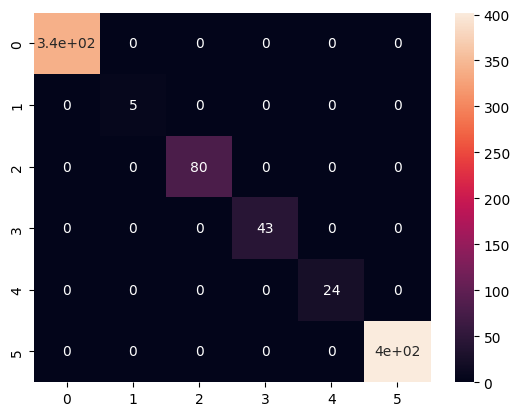

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

Preprocessing and Modelling
To build the corpus from the 'verified_reviews' we perform the following -

Replace any non alphabet characters with a space
Covert to lower case and split into words
Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)